# 0.0 IMPORTS

In [43]:
import pandas as pd
import numpy as np
import inflection
import math
import datetime

import seaborn as sns

import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

## 0.1 Helper Functions

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [ ]:
jupyter_settings()

## LOADING DATA

In [2]:
df_sales_raw = pd.read_csv('C:/Users/Utilizador/repos/Data_Science_em_Producao/data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('C:/Users/Utilizador/repos/Data_Science_em_Producao/data/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 DATA CLEANING

## Data Description

In [3]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [4]:
cols_old = ['Store', 
            'DayOfWeek', 
            'Date', 
            'Sales', 
            'Customers', 
            'Open', 
            'Promo',
            'StateHoliday', 
            'SchoolHoliday', 
            'StoreType', 
            'Assortment',
            'CompetitionDistance', 
            'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 
            'Promo2', 
            'Promo2SinceWeek',
            'Promo2SinceYear', 
            'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# Rename
df1.columns = cols_new
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [5]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [6]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [7]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [9]:
# percentage of missing data by total rows
df1.isna().sum() / df1.shape[0]

store                           0.000000
day_of_week                     0.000000
date                            0.000000
sales                           0.000000
customers                       0.000000
open                            0.000000
promo                           0.000000
state_holiday                   0.000000
school_holiday                  0.000000
store_type                      0.000000
assortment                      0.000000
competition_distance            0.002597
competition_open_since_month    0.317878
competition_open_since_year     0.317878
promo2                          0.000000
promo2_since_week               0.499436
promo2_since_year               0.499436
promo_interval                  0.499436
dtype: float64

## 1.5 Fillout NA (): 
Preencher NA

Formas de se fazer:
- exclui-las
- Machine Learning: input de na (substituir os na pela média por exemplo)
- Entendendo o negócio: lógica do negócio

In [10]:
# competition_distance: distance in meters to the nearest competitor store 
# Definição:  distância em metros até a loja concorrente mais próxima;
# Porque temos NA: podemos entender ue não há uma loja perto, ou a loja está tão longe que não oferece uma competição, ou seja não cobre os mesmos clientes
# Estratégia: vamos substituir os NA por uma valor muito maior que o máximo(75860.0) da coluna competition_distance

# Então temos 75860 metros de distância até o competidor(loja) mais próxima
df1['competition_distance'].max()

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

In [11]:
# competition_open_since_month: gives the approximate year and month of the time the nearest competitor was opened
# Definição:  fornece o mês aproximados da hora em que o concorrente mais próximo foi aberto;
# Porque temos NA:1º: A loja não tem competidor mais próximo, sendo assim não temos uma data de abertura,
#                 2º: Existe uma loja, mas não sabemos quando abriu. Porque tem uma data muito antiga, ou perdeu se essa informação
# Estratégia: Vamos fazer uma cópia das informações (mês) da coluna date para competition_open_since_month

df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month 
                                                if math.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1)

In [12]:
# competition_open_since_year: gives the approximate year and month of the time the nearest competitor was opened
# Definição:  fornece o ano aproximados da hora em que o concorrente mais próximo foi aberto;
# Porque temos NA:1º: A loja não tem competidor mais próximo, sendo assim não temos uma data de abertura,
#                 2º: Existe uma loja, mas não sabemos quando abriu. Porque tem uma data muito antiga, ou perdeu se essa informação
# Estratégia: Vamos fazer uma cópia das informações (ano) da coluna date para a coluna competition_open_since_year

df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year
                                                if math.isnan(x['competition_open_since_year']) 
                                                else x['competition_open_since_year'], axis=1)

In [13]:
# promo2_since_week: describes the year and calendar week when the store started participating in Promo2
# Definição: descreve a semana do calendário em que a loja começou a participar do Promo2(continuação de uma promoção);
# Porque temos NA: A loja decidiu não participar da continuação da promoção,
# Estratégia: Vamos fazer uma cópia das informações (semana) da coluna date para a coluna promo2_since_week

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week
                                                if math.isnan(x['promo2_since_week']) 
                                                else x['promo2_since_week'], axis=1)

In [14]:
# promo2_since_year: describes the year and calendar week when the store started participating in Promo2
# Definição: descreve o ano do calendário em que a loja começou a participar do Promo2(continuação de uma promoção);
# Porque temos NA: A loja decidiu não participar da continuação da promoção,
# Estratégia: Vamos fazer uma cópia das informações (ano) da coluna date para a coluna promo2_since_year

df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year
                                                if math.isnan(x['promo2_since_year']) 
                                                else x['promo2_since_year'], axis=1)

In [15]:
# promo_interval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store
# Definição: descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é iniciada novamente. Por exemplo. "fev, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja;
# Porque temos NA: A loja decidiu não participar da continuação da promoção,
# Estratégia: Vamos criar uma nova coluna,  com insidcação de Ativo, ou seja, a promo2 foi continuada. Caso a coluna data esteje preenchida.

# Criando dicionário que faz a troca do número do mês pelo nome do mês
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec', }

# Substituindo os NA por 0 na coluna promo_interval
df1['promo_interval'].fillna(0, inplace=True)

# Criando nova coluna(month_map) que recebe o mês estraido da coluna date a aplica-se o dicionário para fazer a comparação
df1['month_map'] = df1['date'].dt.month.map(month_map)

# Criando uma nova coluna(is_promo) que recebe 0 ou 1 dependendo da regra de negócio(promo_interval). Ou , se o meu month_map está dentro do intervalo do promo_interval
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [16]:
# Olhar os dados
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
597207,353,7,2014-01-12,5946,1365,1,0,0,0,b,b,900.0,1.0,2014.0,1,14.0,2013.0,"Feb,May,Aug,Nov",Jan,0


In [17]:
# Checando se eliminamos os NA
df1.isna().sum() / df1.shape[0]

store                           0.0
day_of_week                     0.0
date                            0.0
sales                           0.0
customers                       0.0
open                            0.0
promo                           0.0
state_holiday                   0.0
school_holiday                  0.0
store_type                      0.0
assortment                      0.0
competition_distance            0.0
competition_open_since_month    0.0
competition_open_since_year     0.0
promo2                          0.0
promo2_since_week               0.0
promo2_since_year               0.0
promo_interval                  0.0
month_map                       0.0
is_promo                        0.0
dtype: float64

## 1.6 Change Types 


In [18]:
# Após tranformações devemos checar novamente os tipos das colunas
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [19]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

Métricas de dispersão e tendência central

- Ganhar conhecimento de negócio
- Detectar erros

In [21]:
num_attributes = df1.select_dtypes(include=['int64','float64' ])
num_attributes

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,0,0,0,0,1,1900.0,6,2014,1,31,2013,1
1017205,1112,2,0,0,0,0,1,1880.0,4,2006,0,1,2013,0
1017206,1113,2,0,0,0,0,1,9260.0,1,2013,0,1,2013,0
1017207,1114,2,0,0,0,0,1,870.0,1,2013,0,1,2013,0


In [25]:
cat_attributes = df1.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])
cat_attributes

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul
...,...,...,...,...,...
1017204,a,a,a,"Jan,Apr,Jul,Oct",Jan
1017205,a,c,c,0,Jan
1017206,a,a,c,0,Jan
1017207,a,a,c,0,Jan


In [26]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
221938,54,2,7550,648,1,1,0,7170.0,8,2014,1,5,2013,0
997842,703,5,2815,341,1,0,0,80.0,6,2005,0,3,2013,0


In [27]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
394141,0,a,c,0,Jul
674800,0,a,c,"Feb,May,Aug,Nov",Nov


## 1.7.1 Numerical Attributes

In [28]:
# Tendência centra: como os dados estão :

# Média
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T

# Mediana
ct2= pd.DataFrame(num_attributes.apply(np.median)).T

In [29]:
# Dispersão: std, min, max, range, skew(assimetria), kurtosis(calda longa)

d1 = pd.DataFrame(num_attributes.apply(np.std)).T

d2 = pd.DataFrame(num_attributes.apply(np.min)).T

d3 = pd.DataFrame(num_attributes.apply(np.max)).T

d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T

d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T

d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

In [30]:
# concat

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


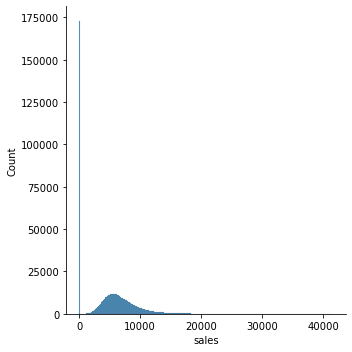

In [31]:
sns.displot(df1['sales'])

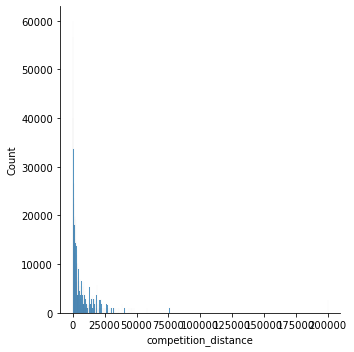

In [32]:
sns.displot(df1['competition_distance'])

## 1.7.2 Categorical Attributes

In [33]:
# Tipo unicos das variaveis categoricas por coluna
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

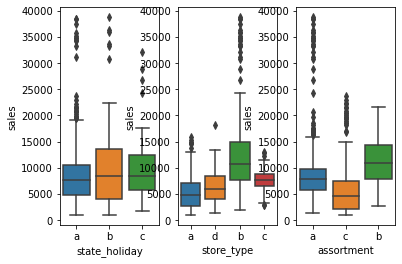

In [34]:
# Boxplot
# Tracinho em cima: valor máximo (Q3+1.5*(Q3-Q1). Tudo qu está acima (pontos acima do tracinho) é outlier(3xdesviopadrão)
# Tracinho em baixo: valor minimo (Q1 - 1.5*(Q3-Q1))
# Linha até o tracinho: (volume dos dados do quartil 75 até 100)
# Linha de cima: 75º quartil (volume dos dados do quartil 50 até 75)
# Linha do meio: Mediana (volume dos dados do quartil )
# Linha de baixo: 25ª  (volume dos dados do quartil 25 até 50)


aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Engineering

In [35]:
df2 = df1.copy()

## 2.1 Hypoteses Mind map

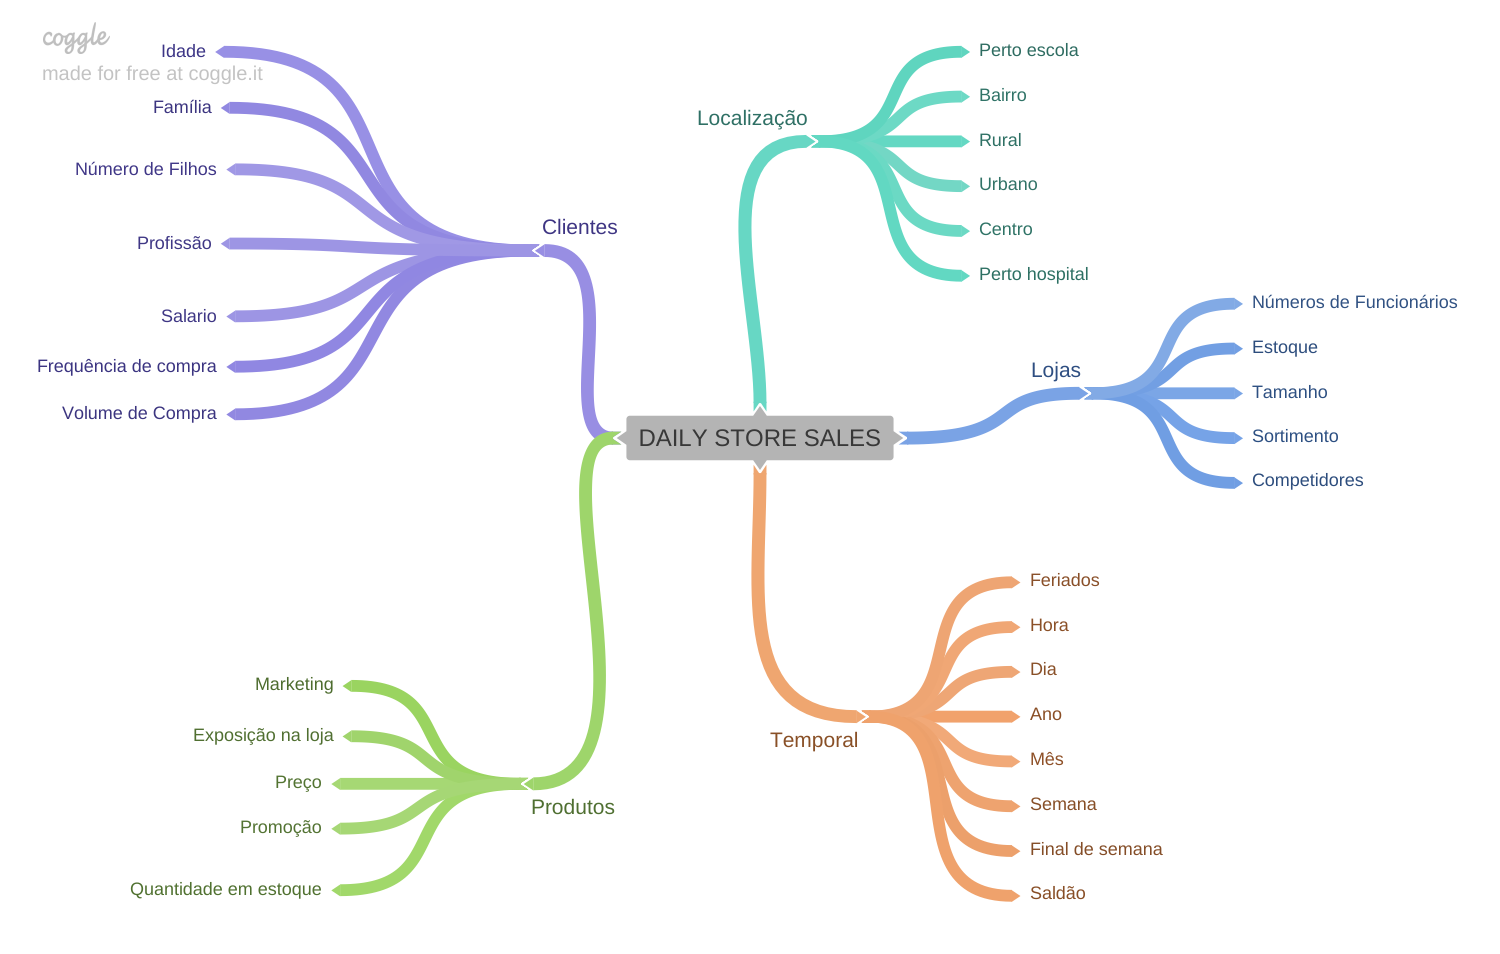

In [36]:
Image('C:/Users/Utilizador/repos/Data_Science_em_Producao/img/Mindmap.png')

Ex: Lojas de maior porte deveriam vender mais;
- Aposta: maior/mais
    - Atributos: porte(tamanho da loja)
        - Variavel resposta: vender
        
Ex: Lojas com maior sortimento deveriam vender mais;
- Aposta: maior/mais
    - Atributos: sortimento(produtos)
        - Variavel resposta: vender
        
Ex: Lojas com mais competidores por perto deveriam vender menos;
- Aposta: mais/menos
    - Atributos: competidores por perto
        - Variavel resposta: vender

## 2.2 Criação de Hipoteses

### 2.2.1 Hipoteses: LOJA

1. Lojas com número maior de funcionários deveriam vender mais. (ainda não tenho dados)
2. Lojas com maior capacidade de estoque deveriam vender mais. (ainda não tenho dados)
3. Lojas com maior porte deveriam vender mais. (ainda não tenho dados)
4. Lojas com maior sortimentos deveriam vender mais. ok
5. Lojas com competidores mais próximos deveriam vender menos. ok
6. Lojas com competidores à mais tempo deveriam vendem mais. ok

### 2.2.2 Hipoteses: PRODUTO

1. Lojas que investem mais em Marketing deveriam vender mais. (ainda não tenho dados)
2. Lojas com maior exposição de produto deveriam vender mais. (ainda não tenho dados)
3. Lojas com produtos com preço menor deveriam vender mais. (ainda não tenho dados)
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais. (ainda não tenho dados)
6. Lojas com promoções ativas por mais tempo deveriam vender mais. ok
7. Lojas com mais dias de promoção deveriam vender mais. ok
8. Lojas com mais promoções consecutivas deveriam vender mais. ok

### 2.2.2 Hipoteses: TEMPO

1. Lojas abertas durante o feriado de Natal deveriam vender mais. ok
2. Lojas deveriam vender mais ao longo dos anos. ok
3. Lojas deveriam vender mais no segundo semestre do ano. ok
4. Lojas deveriam vender mais depois do dia 10 de cada mês. ok
5. Lojas deveriam vender menos aos finais de semana. ok
6. Lojas deveriam vender menos durante os feriados escolares. ok

## Lista Final de Hipóteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares

## 2.3 Feature Engineering: derivando as variaveis

In [37]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

C:\Users\UTILIZ~1\AppData\Local\Temp/ipykernel_364/2268827306.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [38]:
# Nova fórmula a ser usada na conversão week for year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

In [44]:
# competition since: tempo entre duas datas

# Juntar competition_open_since_year and competition_open_since_month em uma nova coluna competition_since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )

# Fazer a diferença entre duas colunas: date - competition_since e atribuir a uma nova coluna: competition_time_month
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

In [45]:
# promo since: tempo entre duas datas

# Join dos caracteres para depois fazer a data
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )

# Convertendo a coluna promo_since(string) em datetime e tranformando os dias em semanas
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

# Fazer a diferença entre duas colunas: date - promo_since e atribuir a uma nova coluna: promo_time_week
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

In [46]:
# assortment: troca das letras pelo texto a, b, c pelos seus respectivos textos
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

In [47]:
# state holiday: troca das letras a, b, c pelos seus respctivos textos
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

In [48]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
